# Tutorial on using the classes for transpiling DBQA strategies into various types of double-bracket rotations (DBRs)

## 1. VQE results are loaded
## 2. The GC3 DBR is shown using  the `GroupCommutatorIterationWithEvolutionOracles` class
### 3.1. It is shown how to perform more steps of the GCI. 
Using the class approach one can just change `mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_third_order_reduced` to a different type and same code will run.

In [2]:
import json
import time
from pathlib import Path

import numpy as np
import qibo
from qibo import hamiltonians, set_backend
from boostvqe.models.dbi.double_bracket import (
    DoubleBracketGeneratorType,
    DoubleBracketIteration,
)

from boostvqe.ansatze import VQE, build_circuit
from boostvqe.utils import apply_dbi_steps, rotate_h_with_vqe
from qibo import symbols, hamiltonians
from copy import deepcopy
from boostvqe.compiling_XXZ import *

import matplotlib.pyplot as plt

## 1. Loading VQE results

In [3]:

qibo.set_backend("numpy")

# set the path string which define the results
path = "../results/vqe_data/with_params/10q7l/sgd_10q_7l_42/"

# set the target epoch to which apply DBQA and the number of steps
target_epoch = 2000
dbi_steps = 1

# upload system configuration and parameters for all the training
with open(path + "optimization_results.json") as file:
    config = json.load(file)

losses = dict(np.load(path + "energies.npz"))["0"]
params = np.load(path + f"parameters/params_ite{target_epoch}.npy")

nqubits = config["nqubits"]
# build circuit, hamiltonian and VQE
hamiltonian = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)
circuit = build_circuit(nqubits, config["nlayers"], "numpy")
vqe = VQE(circuit, hamiltonian)
zero_state = hamiltonian.backend.zero_state(nqubits)
zero_state_t = np.transpose([zero_state])
target_energy = np.min(hamiltonian.eigenvalues())


# set target parameters into the VQE
vqe.circuit.set_parameters(params)
vqe_state = vqe.circuit().state()

ene1 = hamiltonian.expectation(vqe_state)


[Qibo 0.2.9|INFO|2024-06-14 22:31:17]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0
[Qibo 0.2.9|INFO|2024-06-14 22:31:17]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


In the VQE numpy


In [4]:
print(f"VQE energy is {ene1}. \n\
The target energy is {target_energy} which means the difference is {ene1-target_energy}.\n\
The relative difference is {abs(ene1-target_energy)/abs(target_energy)}%.")

VQE energy is -14.856898957126564. 
The target energy is -15.276131122065795 which means the difference is 0.4192321649392312.
The relative difference is 0.02744360869838739%.


# 2. GCI vs GCI3 steps
$D= \sum_i B_i Z_i$
and Group commutator

In [5]:


from boostvqe.models.dbi.group_commutator_iteration_transpiler import *
from boostvqe.models.dbi.double_bracket_evolution_oracles import *


eo_xxz = XXZ_EvolutionOracle(nqubits, steps = 1, order = 2)

# implement the rotate by VQE on the level of circuits
fsoe  = VQERotatedEvolutionOracle(eo_xxz, vqe)


In [11]:
# init gci with the vqe-rotated hamiltonian
gci  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_reduced)
b_list = [1+np.sin(x/3)for x in range(10)]
times = np.linspace(0.003,0.004,10)
eo_d = MagneticFieldEvolutionOracle(b_list,name = "D(linear)")
s,l, ls = gci.choose_step(d = eo_d,times = times)


## First we try the reduced GC

This has the cost 3x VQE + 1x Hamiltonian simulation (HS)

-14.968115403567413


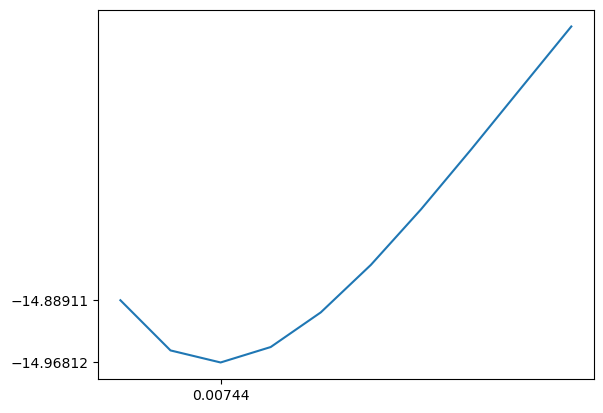

In [13]:
losses = []
times = np.linspace(1e-3,3e-2,10)
for s in times:
    losses.append(gci.loss(s, eo_d))
plt.plot(times,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times[np.argmin(losses)]])
print(min(losses))
s_gci_1 = times[np.argmin(losses)]

## Next we try the reduced GC3

This has the cost 5x VQE + 2x Hamiltonian simulation (HS)

-14.984439569932277


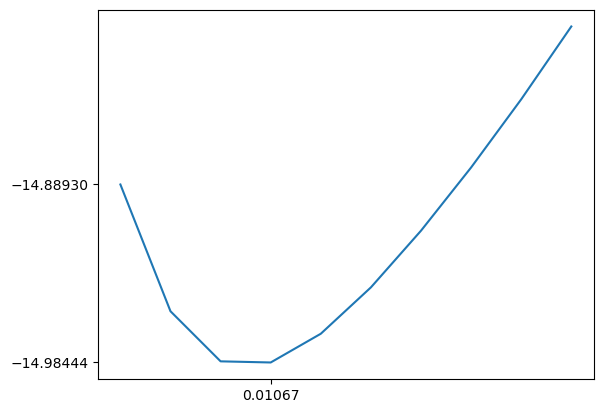

In [16]:
gci.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced
losses = []
times = np.linspace(1e-3,3e-2,10)

for s in times:
    losses.append(gci.loss(s, eo_d))
plt.plot(times,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times[np.argmin(losses)]])
print(min(losses))
s_gc3 = times[np.argmin(losses)]

## Finally we try the reduced GC twice

This has again the cost 5x VQE + 2x HS so anytime we try GC3 we can try to run 2x GC1

-14.952724302438346


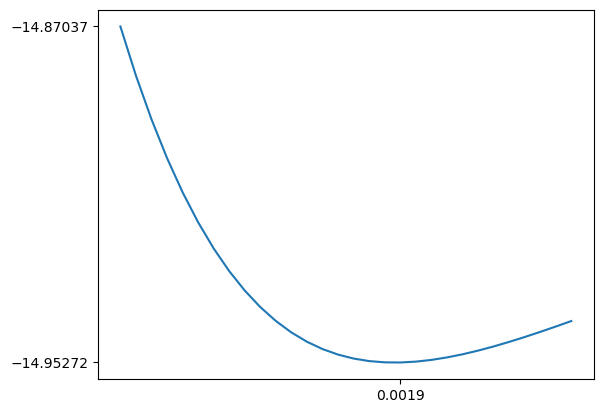

In [19]:
gci.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_reduced

c1 = gci.get_composed_circuit()
losses = []
times_double = np.linspace(1e-4,3e-3,30)
for s in times_double:
    c0 = gci.recursion_step_circuit(s, eo_d)
    losses.append(hamiltonian.expectation((c0+c0+c1)().state()))

plt.plot(times_double,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times_double[np.argmin(losses)]])
print(min(losses))
s_gc1_2_step = times_double[np.argmin(losses)]

In [21]:
c0 = gci.recursion_step_circuit(s_gc1_2_step, eo_d)
v1_circ = c0+c0+c1
hamiltonian.expectation(v1_circ().state())

-14.952724302438346

In [22]:

fsoe2  = FrameShiftedEvolutionOracle(deepcopy(eo_xxz),before_circuit=v1_circ.invert(), after_circuit=v1_circ, name="fixing bug")
# init gci with the vqe-rotated hamiltonian
gci2  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe2, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_reduced)
gci2.print_gate_count_report()
#  this is quite simple - just pass a diagonal SymbolicHamiltonian 
# and because it will be commuting we can use the member function circuit for compiling
gci2.loss()

The boosting circuit used 90 CNOT gates coming from compiled XXZ evolution and 350 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 9.0 and n_CZ/n_qubits = 35.0


-14.952724302438346

In [23]:
gci2.print_gate_count_report()


The boosting circuit used 90 CNOT gates coming from compiled XXZ evolution and 350 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 9.0 and n_CZ/n_qubits = 35.0


# Second DBQA boosting step

Checking histogram for a linspace

-15.008400917714264


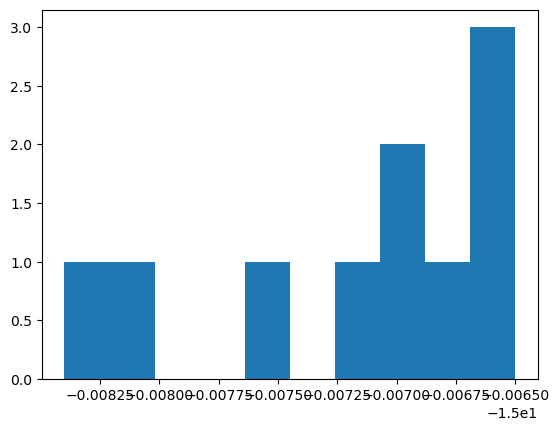

In [24]:
#  this is quite simple - just pass a diagonal SymbolicHamiltonian 
# and because it will be commuting we can use the member function circuit for compiling
fields = []
losses = []
steps = []
for j in range(10):
    field = [a+b for a,b in zip(np.random.rand(10)*.2,np.linspace(1,0,10))]
    eo_d = MagneticFieldEvolutionOracle(field,name = "D(linear)")
    step,loss, _ = gci2.choose_step(d = eo_d,max_evals=34,step_min = 0.0051,step_max = 0.03)
    losses.append(loss)
    fields.append(field)
    steps.append(step)

plt.hist(losses)
print(np.min(losses))


Checking histogram for a linspace with opposite slope

In [25]:
#  this is quite simple - just pass a diagonal SymbolicHamiltonian 
# and because it will be commuting we can use the member function circuit for compiling
fields = []
losses = []
steps = []
for j in range(10):
    field = [a+b for a,b in zip(np.random.rand(10)*.2,np.linspace(0,1,10))]
    eo_d = MagneticFieldEvolutionOracle(field,name = "D(linear)")
    step,loss, _ = gci2.choose_step(d = eo_d,max_evals=34,step_min = 0.0051,step_max = 0.03)
    losses.append(loss)
    fields.append(field)
    steps.append(step)

plt.hist(losses)
print(np.min(losses))

Checking histogram for a constant magnetic field

-15.014739542351847


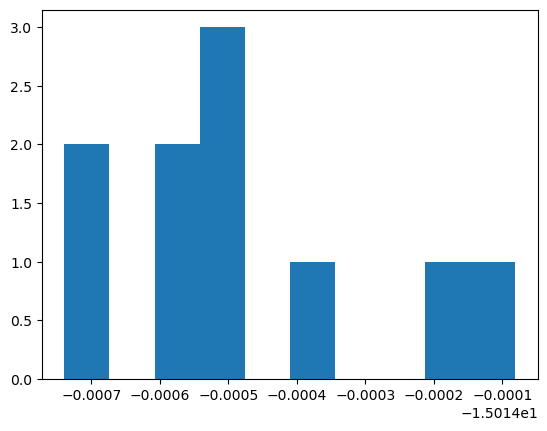

In [26]:
#  this is quite simple - just pass a diagonal SymbolicHamiltonian 
# and because it will be commuting we can use the member function circuit for compiling
fields = []
losses = []
steps = []
for j in range(10):
    field = [a+b for a,b in zip(np.random.rand(10)*.2,np.linspace(1,1,10))]
    eo_d = MagneticFieldEvolutionOracle(field,name = "D(linear)")
    step,loss, _ = gci2.choose_step(d = eo_d,max_evals=34,step_min = 0.0051,step_max = 0.03)
    losses.append(loss)
    fields.append(field)
    steps.append(step)

plt.hist(losses)
print(np.min(losses))

Checking histogram for a linspace with stronger randomization

-15.00942916978238


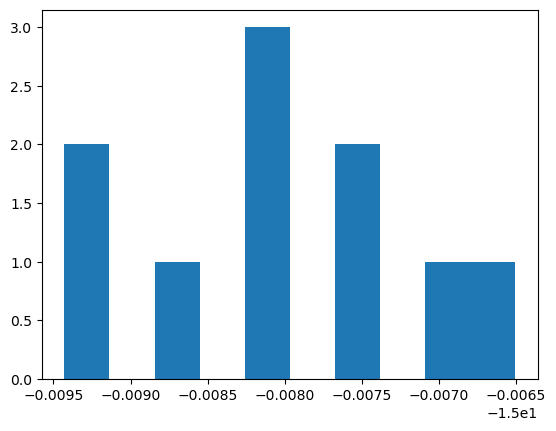

In [27]:
#  this is quite simple - just pass a diagonal SymbolicHamiltonian 
# and because it will be commuting we can use the member function circuit for compiling
fields = []
losses = []
steps = []
for j in range(10):
    field = [a+b for a,b in zip(np.random.rand(10)*.3,np.linspace(1,0,10))]
    eo_d = MagneticFieldEvolutionOracle(field,name = "D(linear)")
    step,loss, _ = gci2.choose_step(d = eo_d,max_evals=34,step_min = 0.0051,step_max = 0.03)
    losses.append(loss)
    fields.append(field)
    steps.append(step)

plt.hist(losses)
print(np.min(losses))

-15.014792161776082


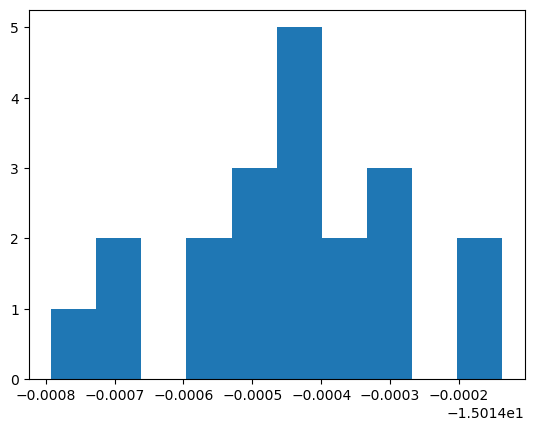

In [28]:
#  this is quite simple - just pass a diagonal SymbolicHamiltonian 
# and because it will be commuting we can use the member function circuit for compiling
fields = []
losses = []
steps = []
for j in range(20):
    field = [a+b for a,b in zip(np.random.rand(10)*.2,np.linspace(1,1,10))]
    eo_d = MagneticFieldEvolutionOracle(field,name = "D(linear)")
    step,loss, _ = gci2.choose_step(d = eo_d,max_evals=34,step_min = 0.0051,step_max = 0.03)
    losses.append(loss)
    fields.append(field)
    steps.append(step)

plt.hist(losses)
print(np.min(losses))

In [31]:
print(np.min(losses))

-15.014792161776082


In [29]:
f = fields[np.argmin(losses)]
s = steps[np.argmin(losses)]

In [30]:
from boostvqe.models.dbi.utils_gci_optimization import *

d_params_test, s, min_loss = gradient_descent_circuits(
gci2,
 train_epochs=10,
   d_params_init=f,
   lr=10
)

-15.004366741561691
0


KeyboardInterrupt: 